# OCR Expiry Date and Production Code Detection with EasyOCR

Name: Anthony Kevin Oktavius

In [1]:
! pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 15.2 MB/s eta 0:00:00


In [2]:
! pip install opencv-python-headless

Download Fonts

In [2]:
! wget https://github.com/jondot/dotfiles/raw/master/.fonts/calibri.ttf

--2023-11-06 04:37:59--  https://github.com/jondot/dotfiles/raw/master/.fonts/calibri.ttf
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jondot/dotfiles/master/.fonts/calibri.ttf [following]
--2023-11-06 04:37:59--  https://raw.githubusercontent.com/jondot/dotfiles/master/.fonts/calibri.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 352736 (344K) [application/octet-stream]
Saving to: ‘calibri.ttf’

calibri.ttf         100%[===================>] 344.47K  --.-KB/s    in 0.04s   

2023-11-06 04:37:59 (7.97 MB/s) - ‘calibri.ttf’ saved [352736/352736]



In [3]:
from google.colab.patches import cv2_imshow
from PIL import ImageFont, ImageDraw, Image, ImageFilter, ImageOps, ImageEnhance
from easyocr import Reader
from datetime import datetime

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf

Set the languages that we'd like to work with.

In [4]:
languages_list = ['en']

Make the process faster by using GPU.

In [5]:
gpu = True

## Data Preparation

In [6]:
! unzip -qq /content/drive/MyDrive/Dataset/Test-OCR.zip

List all of the files for testing.

In [7]:
TEST_OCR_DIR = "Test-OCR"

date_real_paths = list(os.listdir(TEST_OCR_DIR))
print(date_real_paths)

['Image_20231103153428429.bmp', 'Image_20231103154043801.bmp', 'Image_20231103153630624.bmp', 'Image_20231103153649469.bmp', 'Image_20231103154101029.bmp', 'Image_20231103154009502.bmp', 'Image_20231103154207260.bmp', 'Image_20231103153733509.bmp', 'Image_20231103153515942.bmp', 'Image_20231103153842005.bmp']


## Data Preprocessing

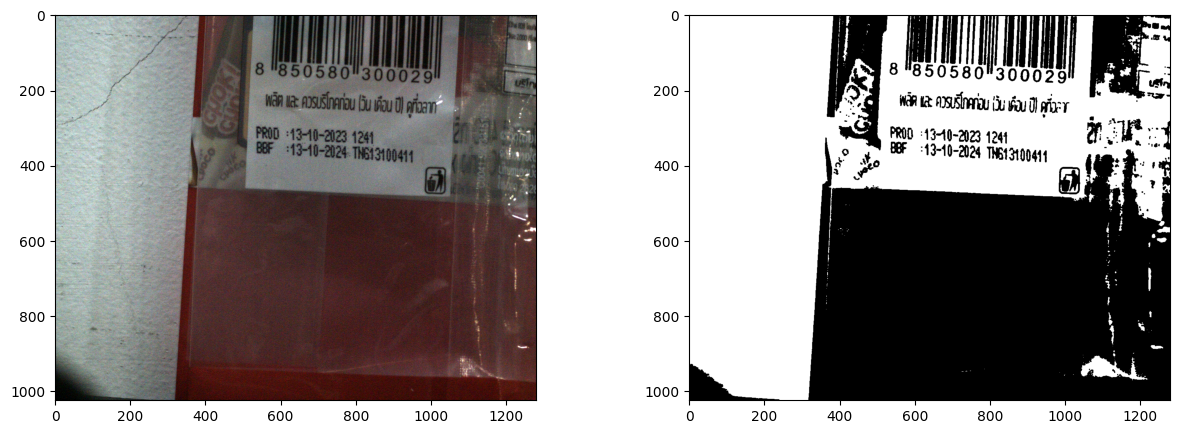

In [37]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Increase brightness
    BRIGHTNESS_FACTOR = 1.7
    image = cv2.convertScaleAbs(image, alpha=BRIGHTNESS_FACTOR, beta=0)

    # Perform Erosion
    kernel = np.ones((3, 3), np.uint8)
    image = cv2.GaussianBlur(image, (3, 3), 0)
    _, image = cv2.threshold(image, 130, 255, cv2.THRESH_BINARY)
    image = cv2.dilate(image, kernel, iterations=1)
    image = cv2.erode(image, kernel, iterations=1)
    return np.array(image)

example_image_path = f"{TEST_OCR_DIR}/{date_real_paths[0]}"

plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
image = Image.open(example_image_path)
image = np.array(image)
plt.imshow(image)

plt.subplot(1, 2, 2)
image = preprocess_image(example_image_path)
plt.imshow(image, cmap = "gray")

plt.show()

## Data Modelling

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

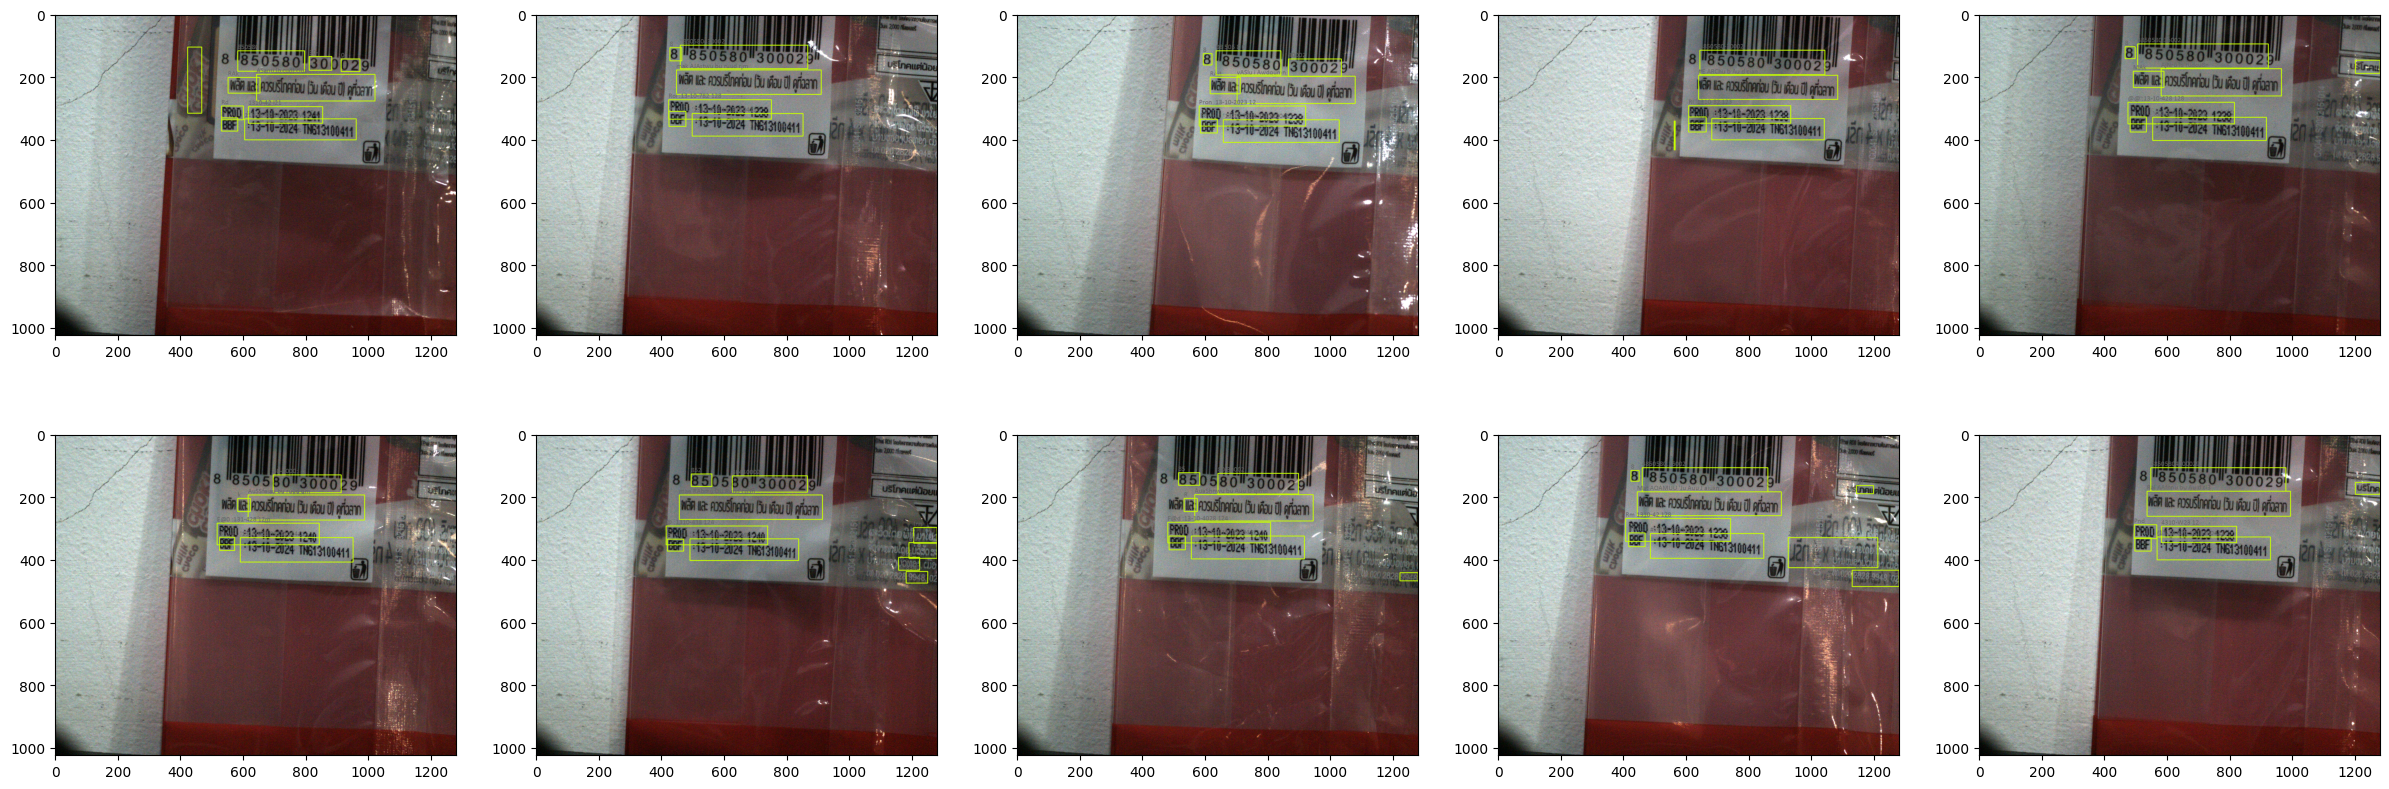

In [9]:
def get_image(path):
  image = Image.open(path)
  return image

def write_text(text, x, y, image, font, color = (100, 100, 100), font_size = 22):
  font = ImageFont.truetype(font, font_size)
  image_pil = Image.fromarray(image)
  draw = ImageDraw.Draw(image_pil)
  draw.text((x, y - font_size), text, font = font, fill = color)
  image = np.array(image_pil)
  return image

def get_box_coordinates(bounding_box):
  (left_top, right_top, bottom_right, bottom_left) = bounding_box
  left_top = (int(left_top[0]), int(left_top[1]))
  right_top = (int(right_top[0]), int(right_top[1]))
  bottom_right = (int(bottom_right[0]), int(bottom_right[1]))
  bottom_left = (int(bottom_left[0]), int(bottom_left[1]))
  return left_top, right_top, bottom_right, bottom_left

def draw_ocr_box_on_img(image, left_top, bottom_right, color = (200, 255, 0), thickness = 2):
  cv2.rectangle(image, left_top, bottom_right, color, thickness)
  return image

font = '/content/calibri.ttf'

N_ROWS = 2
N_COLS = 5
THRESHOLD = 0.1

images_border_informations = []
reader = Reader(languages_list, gpu)

plt.figure(figsize = (30, 10))
for path_index, path in enumerate(date_real_paths):
  image = get_image(f"{TEST_OCR_DIR}/{path}")
  preprocessed_image = preprocess_image(f"{TEST_OCR_DIR}/{path}")
  results = reader.readtext(np.array(preprocessed_image))
  image = np.array(image)

  bboxes = []
  texts = []

  for (box, text, probability) in results:
    left_top, right_top, bottom_right, bottom_left = get_box_coordinates(box)

    image = draw_ocr_box_on_img(
      image, left_top = left_top, bottom_right = bottom_right,
    )

    image = write_text(text, left_top[0], left_top[1], image, font)

    bboxes.append([left_top, right_top, bottom_right, bottom_left])
    texts.append(text)

  image_border_information = {
      "bboxes": bboxes,
      "texts": texts,
  }

  images_border_informations.append(image_border_information)

  plt.subplot(N_ROWS, N_COLS, path_index + 1)
  plt.imshow(image)

Save the border informations with pickle

In [14]:
image_border_informations_path = "drive/MyDrive/Models/ocr_image_border_informations.pickle"

In [13]:
import pickle
pickle.dump(images_border_informations, open(image_border_informations_path, "wb"))

In [15]:
image_border_informations = pickle.load(open(image_border_informations_path, "rb"))
image_border_informations

[{'bboxes': [[(583, 117), (796, 117), (796, 182), (583, 182)],
   [(811, 135), (883, 135), (883, 179), (811, 179)],
   [(913, 143), (973, 143), (973, 183), (913, 183)],
   [(552, 202), (654, 202), (654, 252), (552, 252)],
   [(643, 192), (1021, 192), (1021, 277), (643, 277)],
   [(531, 293), (601, 293), (601, 337), (531, 337)],
   [(617, 295), (854, 295), (854, 348), (617, 348)],
   [(531, 331), (583, 331), (583, 373), (531, 373)],
   [(605, 334), (961, 334), (961, 401), (605, 401)],
   [(423, 105), (501, 116), (468, 316), (390, 304)]],
  'texts': ['850580',
   '30-',
   '02',
   'RAk',
   'ASanu lb cud) ciut',
   'Rd',
   '1310-42 I21',
   '8',
   '11H10-02 1613100M11',
   '8']},
 {'bboxes': [[(427, 107), (465, 107), (465, 149), (427, 149)],
   [(460, 99), (867, 99), (867, 174), (460, 174)],
   [(448, 178), (910, 178), (910, 256), (448, 256)],
   [(423, 273), (751, 273), (751, 335), (423, 335)],
   [(424, 310), (478, 310), (478, 358), (424, 358)],
   [(498, 317), (852, 317), (852, 389

## Post Preprocessing

Define function to extract the information from production code and expire date only.

The code logic:

* Find all date texts from all of the bounding boxes.
* Get all of nearest bounding boxes from date, then perform union from all of the  (left/right/up/down)
* Concat all of the texts above, so it can produce the accurate result.

In [11]:
def union_bbox(bbox_1, bbox_2):
    """Union two bounding boxes."""
    x11, y11, x21, y21 = bbox_1
    x12, y12, x22, y22 = bbox_2
    return min(x11, x12), min(y11, y12), max(x21, x22), max(y21, y22)

def are_boxes_overlapping(box1, box2):
    # Extract coordinates from the bounding boxes
    x1_box1, y1_box1, x2_box1, y2_box1 = box1
    x1_box2, y1_box2, x2_box2, y2_box2 = box2

    # Check if the boxes overlap in both X and Y dimensions
    overlap_x = (x1_box1 < x2_box2) and (x2_box1 > x1_box2)
    overlap_y = (y1_box1 < y2_box2) and (y2_box1 > y1_box2)

    # If both dimensions overlap, the boxes overlap
    return overlap_x and overlap_y

def is_date(text):
  try:
    datetime.strptime(text, '%a %b %d %Y').strftime('%d/%m/%Y')
    return True
  except ValueError as e:
    print(f"Error date triggered for text: {text}!")
    return False

for path_index, path in enumerate(date_real_paths):
  for image in images_border_informations.items():
